In [1]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
seed = 0
np.random.seed(seed)

In [3]:
train_file = 'data/Beef_TRAIN'

In [4]:
test_file = 'data/Beef_TEST'

In [5]:
sampling_rate = 5

# Prep Train Data

In [6]:
train_data = np.loadtxt(train_file)

In [7]:
np.random.shuffle(train_data)

In [8]:
X_train = train_data[:,1:]

In [9]:
y_train = train_data[:,0]

In [ ]:
print(X_train[0])

In [ ]:
print(y_train)

In [10]:
X_train.shape

(30, 470)

In [11]:
y_train.shape

(30,)

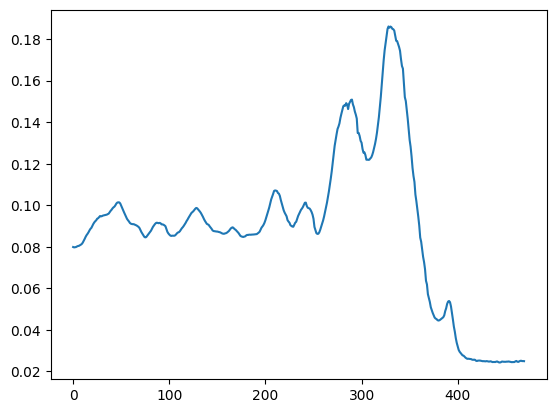

In [12]:
plt.plot(X_train[1])
plt.show()

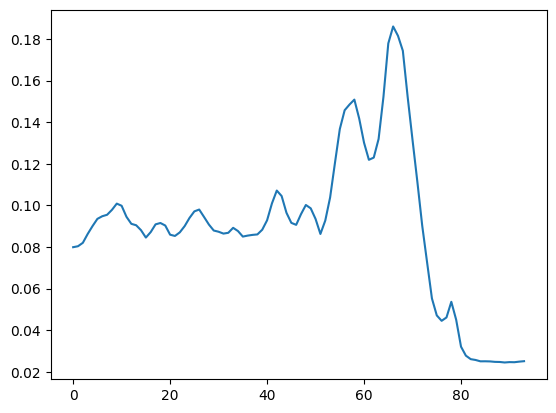

In [13]:
plt.plot(X_train[1, ::sampling_rate])
plt.show()

In [14]:
X_train_sampling = X_train[:, ::sampling_rate]

In [15]:
X_train_sampling.shape

(30, 94)

# Prep Test Data

In [16]:
test_data = np.loadtxt(test_file)

In [17]:
np.random.shuffle(test_data)

In [18]:
X_test = test_data[:,1:]

In [19]:
y_test = test_data[:,0]

In [ ]:
print(X_test[0])

In [ ]:
print(y_test[0])

In [20]:
X_test_sampling = X_test[:, ::sampling_rate]

In [21]:
X_test_sampling.shape

(30, 94)

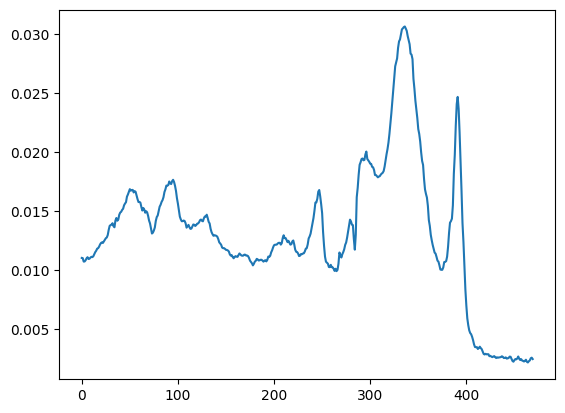

In [22]:
plt.plot(X_test[0])
plt.show()

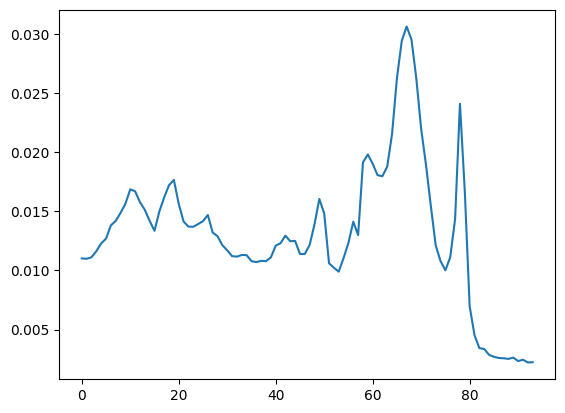

In [23]:
plt.plot(X_test_sampling[0])
plt.show()

# Train Model

In [24]:
def DTW(a, b):
    # ถ้า DTW  ทำช้าอาจต้องทำ sampling เพื่อลดปริมาณ data ทำ DTW จะได้เร็วขึ้น    
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [25]:
def DTWWithWeightNeighborCell(a,b,**kwargs):
    # print("weight",kwargs["alpha"],kwargs["beta"],kwargs["gamma"])
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([kwargs["alpha"]*cumdist[ai, bi+1],
                                   kwargs["beta"]*cumdist[ai, bi],
                                   kwargs["gamma"]*cumdist[ai+1, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

# Test Symmetric Model

In [32]:
clf = KNeighborsClassifier(metric =DTW,n_neighbors=1,n_jobs=-1)
clf.fit(X_train_sampling, y_train)

KNeighborsClassifier(metric=<function DTW at 0x0000020EA6D06830>, n_jobs=-1,
                     n_neighbors=1)

In [33]:
y_pred = clf.predict(X_test_sampling)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.75      1.00      0.86         6
         2.0       0.33      0.17      0.22         6
         3.0       0.50      0.67      0.57         6
         4.0       0.40      0.33      0.36         6
         5.0       0.33      0.33      0.33         6

    accuracy                           0.50        30
   macro avg       0.46      0.50      0.47        30
weighted avg       0.46      0.50      0.47        30



# Create Model with weight neighboring cells [Test Asymmetric]

In [26]:
def createMetricParams(alphaMax,betaMax,gammaMax):
    metricParamsArray = []
    for i in range(1,alphaMax+1):
        for j in range(1,betaMax+1):
            for k in range(1,gammaMax+1):
                if (i == k):
                    continue
                metricParam = {"alpha":i,"beta":j,"gamma":k}
                metricParamsArray.append(metricParam)
    return metricParamsArray

In [39]:
createMetricParams(2,2,2)

[{'alpha': 1, 'beta': 1, 'gamma': 2},
 {'alpha': 1, 'beta': 2, 'gamma': 2},
 {'alpha': 2, 'beta': 1, 'gamma': 1},
 {'alpha': 2, 'beta': 2, 'gamma': 1}]

In [40]:
parameters = {'n_neighbors':[1],'metric_params':createMetricParams(5,5,5)}
clf = GridSearchCV(KNeighborsClassifier(metric =DTWWithWeightNeighborCell), parameters, cv=2,verbose=10,n_jobs=-1)
clf.fit(X_train_sampling, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


GridSearchCV(cv=2,
             estimator=KNeighborsClassifier(metric=<function DTWWithWeightNeighborCell at 0x0000020EE5503C70>),
             n_jobs=-1,
             param_grid={'metric_params': [{'alpha': 1, 'beta': 1, 'gamma': 2},
                                           {'alpha': 1, 'beta': 1, 'gamma': 3},
                                           {'alpha': 1, 'beta': 1, 'gamma': 4},
                                           {'alpha': 1, 'beta': 1, 'gamma': 5},
                                           {'alpha': 1, 'beta': 2, 'gamma': 2},
                                           {'alpha': 1, 'beta': 2, 'gamma': 3},
                                           {'alpha': 1, '...
                                           {'alpha': 1, 'beta': 5, 'gamma': 5},
                                           {'alpha': 2, 'beta': 1, 'gamma': 1},
                                           {'alpha': 2, 'beta': 1, 'gamma': 3},
                                           {'alpha': 2, 'beta': 1, 'gamma': 4},
                                           {'alpha': 2, 'beta': 1, 'gamma': 5},
                                           {'alpha': 2, 'beta': 2, 'gamma': 1},
                                           {'alpha': 2, 'beta': 2, 'gamma': 3},
                                           {'alpha': 2, 'beta': 2, 'gamma': 4},
                                           {'alpha': 2, 'beta': 2, 'gamma': 5},
                                           {'alpha': 2, 'beta': 3, 'gamma': 1},
                                           {'alpha': 2, 'beta': 3, 'gamma': 3}, ...],
                         'n_neighbors': [1]},
             verbose=10)

In [42]:
grid_search_result = clf.cv_results_
grid_search_result_pd = pd.DataFrame.from_dict(grid_search_result)

In [43]:
grid_search_result_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000998,1.192093e-07,45.566844,0.286547,"{'alpha': 1, 'beta': 1, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.333333,0.400000,0.366667,0.033333,97
1,0.001500,5.073547e-04,45.736395,0.046992,"{'alpha': 1, 'beta': 1, 'gamma': 3}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.333333,0.466667,0.400000,0.066667,69
2,0.001000,1.549721e-06,45.134293,0.124009,"{'alpha': 1, 'beta': 1, 'gamma': 4}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.333333,0.466667,0.400000,0.066667,69
3,0.000996,2.503395e-06,45.332800,0.108503,"{'alpha': 1, 'beta': 1, 'gamma': 5}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.333333,0.466667,0.400000,0.066667,69
4,0.001497,4.966259e-04,46.257397,0.360001,"{'alpha': 1, 'beta': 2, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 2, 'gam...",0.400000,0.466667,0.433333,0.033333,19
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001000,1.072884e-06,49.776765,0.021901,"{'alpha': 5, 'beta': 4, 'gamma': 4}",1,"{'metric_params': {'alpha': 5, 'beta': 4, 'gam...",0.400000,0.466667,0.433333,0.033333,19
96,0.000998,2.980232e-06,32.706876,0.555769,"{'alpha': 5, 'beta': 5, 'gamma': 1}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.333333,0.466667,0.400000,0.066667,69
97,0.001003,4.768372e-07,32.055705,0.315491,"{'alpha': 5, 'beta': 5, 'gamma': 2}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.400000,0.466667,0.433333,0.033333,19
98,0.000995,1.907349e-06,31.398715,0.065498,"{'alpha': 5, 'beta': 5, 'gamma': 3}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.400000,0.466667,0.433333,0.033333,19


In [44]:
grid_search_result_pd[grid_search_result_pd['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
9,0.000997,3.099442e-06,46.559487,0.164001,"{'alpha': 1, 'beta': 3, 'gamma': 3}",1,"{'metric_params': {'alpha': 1, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
10,0.001000,9.536743e-07,46.917395,0.210998,"{'alpha': 1, 'beta': 3, 'gamma': 4}",1,"{'metric_params': {'alpha': 1, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
11,0.000999,9.536743e-07,46.365396,0.128997,"{'alpha': 1, 'beta': 3, 'gamma': 5}",1,"{'metric_params': {'alpha': 1, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
29,0.001004,3.457069e-06,45.245664,0.116496,"{'alpha': 2, 'beta': 3, 'gamma': 3}",1,"{'metric_params': {'alpha': 2, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
30,0.001502,4.986525e-04,45.106160,0.035997,"{'alpha': 2, 'beta': 3, 'gamma': 4}",1,"{'metric_params': {'alpha': 2, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
31,0.001002,0.000000e+00,45.155162,0.060001,"{'alpha': 2, 'beta': 3, 'gamma': 5}",1,"{'metric_params': {'alpha': 2, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
48,0.001003,2.026558e-06,44.716938,0.094499,"{'alpha': 3, 'beta': 3, 'gamma': 1}",1,"{'metric_params': {'alpha': 3, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
49,0.000501,5.005598e-04,44.723935,0.052499,"{'alpha': 3, 'beta': 3, 'gamma': 2}",1,"{'metric_params': {'alpha': 3, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
50,0.000499,4.990101e-04,44.884938,0.164501,"{'alpha': 3, 'beta': 3, 'gamma': 4}",1,"{'metric_params': {'alpha': 3, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1
51,0.001002,3.576279e-07,45.675937,0.279499,"{'alpha': 3, 'beta': 3, 'gamma': 5}",1,"{'metric_params': {'alpha': 3, 'beta': 3, 'gam...",0.466667,0.466667,0.466667,0.0,1


In [45]:
model = clf.best_estimator_

In [46]:
y_pred = model.predict(X_test_sampling)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.60      1.00      0.75         6
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00         6
         4.0       0.22      0.33      0.27         6
         5.0       0.50      0.50      0.50         6

    accuracy                           0.37        30
   macro avg       0.26      0.37      0.30        30
weighted avg       0.26      0.37      0.30        30



จาก db BEEF เราจะเห็นว่า Symmetric ดีกว่า Asymmetric